# CNN Modeling - Standard Approach
Neil Kanungo, December 2024

In [65]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [66]:
class RULPredictor:
    def __init__(self, input_shape, config=None):
        self.input_shape = input_shape
        self.config = config if config else {}
        self.model = self._build_model()
        
    def _build_model(self):
        model = Sequential([
            layers.Conv1D(
                filters=self.config.get('filters_conv1', 64),
                kernel_size=self.config.get('kernel_size_conv1', 3),
                activation=self.config.get('activation_conv1', 'sigmoid'),
                input_shape=self.input_shape
            ),
            layers.BatchNormalization(),
            
            layers.Conv1D(
                filters=self.config.get('filters_conv2', 384),
                kernel_size=self.config.get('kernel_size_conv2', 5),
                activation=self.config.get('activation_conv2', 'relu')
            ),
            layers.BatchNormalization(),
            
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(),
            
            layers.Dense(
                self.config.get('dense_neurons', 50),
                activation=self.config.get('activation_dense', 'relu')
            ),
            
            layers.Dense(1)
        ])
        
        model.compile(
            optimizer=optimizers.Adam(
                learning_rate=self.config.get('learning_rate', 0.001)
            ),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[
                tf.keras.metrics.MeanSquaredError(),
                tf.keras.metrics.MeanAbsoluteError()
            ]
        )
        
        return model

In [67]:
class GridSearch:
    def __init__(self, param_grid, input_shape):
        self.param_grid = param_grid
        self.input_shape = input_shape
        self.results = []
        self.best_params = None
        self.best_score = float('inf')
        
    def fit(self, train_data, train_targets, test_data, test_targets):
        param_combinations = ParameterGrid(self.param_grid)
        total_combinations = len(param_combinations)
        
        print(f"Starting grid search with {total_combinations} combinations")
        
        for i, params in enumerate(param_combinations, 1):
            print(f"\nTrying combination {i}/{total_combinations}")
            print("Parameters:", params)
            
            predictor = RULPredictor(self.input_shape, params)
            
            history = predictor.model.fit(
                train_data,
                train_targets,
                validation_data=(test_data, test_targets),
                epochs=params.get('epochs', 4),
                batch_size=params.get('batch_size', 32),
                verbose=1
            )
            
            y_pred = predictor.model.predict(test_data, verbose=0)
            rmse = np.sqrt(mean_squared_error(test_targets, y_pred))
            mae = mean_absolute_error(test_targets, y_pred)
            r2 = r2_score(test_targets, y_pred)
            
            result = {
                'params': params,
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'val_loss': min(history.history['val_loss'])
            }
            self.results.append(result)
            
            if rmse < self.best_score:
                self.best_score = rmse
                self.best_params = params
                predictor.model.save('best_model.keras')
            
            self._save_results()
            
        return self.results
    
    def _save_results(self):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Convert results to DataFrame
        results_list = []
        for result in self.results:
            result_dict = {
                'rmse': result['rmse'],
                'mae': result['mae'],
                'r2': result['r2'],
                'val_loss': result['val_loss']
            }
            # Add parameters to the dictionary
            for param_name, param_value in result['params'].items():
                result_dict[f'param_{param_name}'] = param_value
            results_list.append(result_dict)
            
        results_df = pd.DataFrame(results_list)
        results_df.to_csv(f'logs/grid_search_results_{timestamp}.csv', index=False)
        
        if self.best_params:
            with open(f'logs/best_params_{timestamp}.json', 'w') as f:
                json.dump(self.best_params, f, indent=4)
    
    def plot_results(self):
        # Convert results to DataFrame for plotting
        results_list = []
        for result in self.results:
            result_dict = {
                'rmse': result['rmse'],
                'mae': result['mae'],
                'r2': result['r2'],
                'val_loss': result['val_loss']
            }
            for param_name, param_value in result['params'].items():
                result_dict[f'param_{param_name}'] = param_value
            results_list.append(result_dict)
            
        results_df = pd.DataFrame(results_list)
        
        plt.figure(figsize=(15, 5))
        
        # Plot RMSE distribution
        plt.subplot(131)
        sns.histplot(results_df['rmse'], kde=True)
        plt.axvline(self.best_score, color='r', linestyle='--', label='Best Score')
        plt.title('RMSE Distribution')
        plt.legend()
        
        # Plot key parameter relationships
        params_to_plot = ['param_filters_conv1', 'param_filters_conv2']
        for i, param in enumerate(params_to_plot, 1):
            if param in results_df.columns:
                plt.subplot(1, 3, i+1)
                sns.scatterplot(data=results_df, x=param, y='rmse')
                plt.title(f'RMSE vs {param.replace("param_", "")}')
        
        plt.tight_layout()
        plt.show()

In [68]:
# Load data
data_path = '../../data/processed_data_pickle_files_no_smoothing/'

print("Loading data...")
with open(data_path + 'test_data_batches.pkl', 'rb') as file:
    test_data = pickle.load(file)
with open(data_path + 'train_data_batches.pkl', 'rb') as file:
    train_data = pickle.load(file)    
with open(data_path + 'train_target_values.pkl', 'rb') as file:
    train_targets = pickle.load(file)
with open(data_path + 'true_rul_values.pkl', 'rb') as file:
    test_targets = pickle.load(file)

print("\nData shapes:")
print(f"Train data: {train_data.shape}")
print(f"Test data: {test_data.shape}")
print(f"Train targets: {train_targets.shape}")
print(f"Test targets: {test_targets.shape}")

Loading data...

Data shapes:
Train data: (17731, 30, 14)
Test data: (100, 30, 14)
Train targets: (17731,)
Test targets: (100,)


In [69]:
# Define parameter grid
param_grid = {
'''
    'filters_conv1': [16, 32, 48, 64, 80, 96, 112, 128],
    'kernel_size_conv1': [2, 3, 4, 5, 6, 8],
    'activation_conv1': ['sigmoid', 'tanh', 'relu'],
    'filters_conv2': [16, 32, 48, 64, 80, 96, 128, 256, 384, 512],
    'kernel_size_conv2': [2, 3, 4, 5, 6, 8, 10],
    'activation_conv2': ['sigmoid', 'tanh', 'relu'],
    'dense_neurons': [20, 40, 60, 80, 100, 200, 300, 400, 500],
    'learning_rate': [0.001],
    'batch_size': [32],
    'epochs': [3, 4, 5, 6, 9, 15]
'''
    'filters_conv1': [32, 64, 128],
    'kernel_size_conv1': [3, 6],
    'activation_conv1': ['sigmoid', 'tanh', 'relu'],
    'filters_conv2': [32, 128, 384, 512],
    'kernel_size_conv2': [2, 5, 10],
    'activation_conv2': ['sigmoid', 'tanh', 'relu'],
    'dense_neurons': [20, 50, 80, 100],
    'learning_rate': [0.001],
    'batch_size': [32],
    'epochs': [4]
}

print("Initializing grid search...")
grid_search = GridSearch(param_grid, input_shape=(train_data.shape[1], train_data.shape[2]))

print("\nPerforming grid search...")
results = grid_search.fit(train_data, train_targets, test_data, test_targets)

Initializing grid search...

Performing grid search...
Starting grid search with 2592 combinations

Trying combination 1/2592
Parameters: {"\n    'filters_conv1': [16, 32, 48, 64, 80, 96, 112, 128],\n    'kernel_size_conv1': [2, 3, 4, 5, 6, 8],\n    'activation_conv1': ['sigmoid', 'tanh', 'relu'],\n    'filters_conv2': [16, 32, 48, 64, 80, 96, 128, 256, 384, 512],\n    'kernel_size_conv2': [2, 3, 4, 5, 6, 8, 10],\n    'activation_conv2': ['sigmoid', 'tanh', 'relu'],\n    'dense_neurons': [20, 40, 60, 80, 100, 200, 300, 400, 500],\n    'learning_rate': [0.001],\n    'batch_size': [32],\n    'epochs': [3, 4, 5, 6, 9, 15]\nfilters_conv1": 32, 'activation_conv1': 'sigmoid', 'activation_conv2': 'sigmoid', 'batch_size': 32, 'dense_neurons': 20, 'epochs': 4, 'filters_conv2': 32, 'kernel_size_conv1': 3, 'kernel_size_conv2': 2, 'learning_rate': 0.001}
Epoch 1/4
555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 2016.5930 - mean_absolute_error: 32.0606 - mean_squared_error: 2016.5930 - val_loss: 4

c:\Program Files\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2080.6584 - mean_absolute_error: 32.5850 - mean_squared_error: 2080.6584 - val_loss: 392.0095 - val_mean_absolute_error: 15.7414 - val_mean_squared_error: 392.0095
Epoch 2/4
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 241.3103 - mean_absolute_error: 12.2410 - mean_squared_error: 241.3103 - val_loss: 269.7583 - val_mean_absolute_error: 12.4373 - val_mean_squared_error: 269.7583
Epoch 3/4
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 183.0938 - mean_absolute_error: 10.5172 - mean_squared_error: 183.0938 - val_loss: 272.5898 - val_mean_absolute_error: 12.4994 - val_mean_squared_error: 272.5898
Epoch 4/4
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 148.8337 - mean_absolute_error: 9.4569 - mean_squared_error: 148.8337 - val_loss: 286.8345 - val_mean_absolute_error: 12.7613 - val_mean_squared_error: 286.8345

Trying combination 3/2592
Parameters: {"\n    'filters_conv1': [16, 32, 48, 64, 80, 96, 112, 128],\n    'kernel_size_conv1':

c:\Program Files\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2443.6235 - mean_absolute_error: 35.1668 - mean_squared_error: 2443.6235 - val_loss: 252.3878 - val_mean_absolute_error: 11.9807 - val_mean_squared_error: 252.3878
Epoch 2/4
 64/555 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 246.3082 - mean_absolute_error: 12.1528 - mean_squared_error: 246.3082

KeyboardInterrupt: 

Plotting results...


c:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


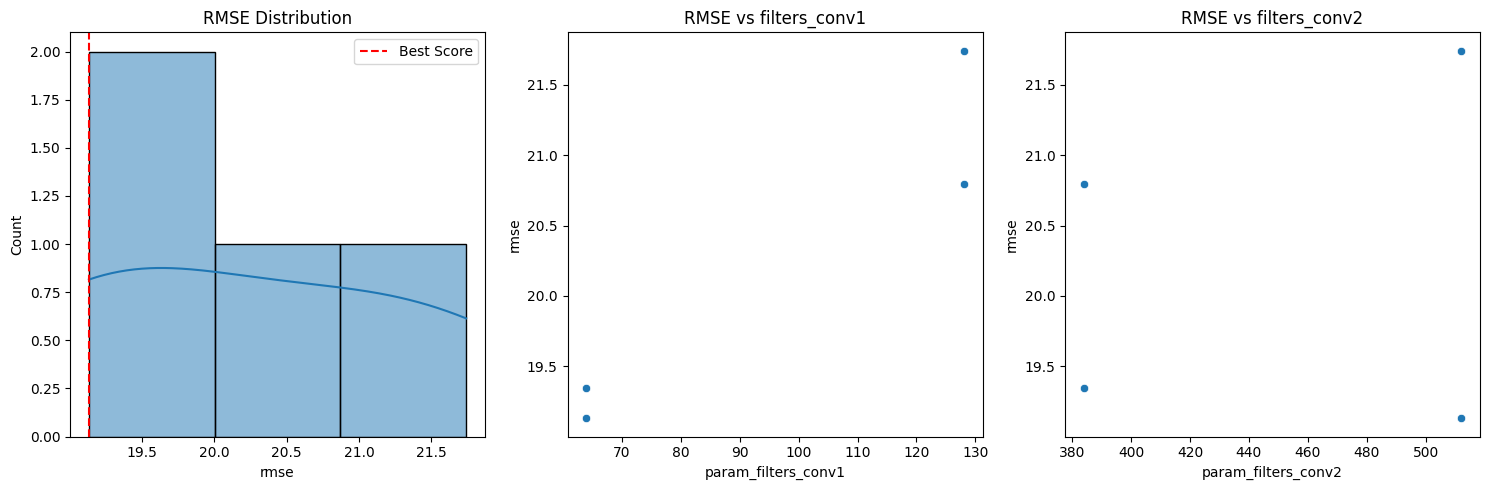


Best Parameters:
{
    "activation_conv1": "sigmoid",
    "activation_conv2": "relu",
    "batch_size": 32,
    "dense_neurons": 50,
    "epochs": 4,
    "filters_conv1": 64,
    "filters_conv2": 512,
    "kernel_size_conv1": 3,
    "kernel_size_conv2": 5,
    "learning_rate": 0.001
}
Best RMSE: 19.1313


In [ ]:
print("Plotting results...")
grid_search.plot_results()

print("\nBest Parameters:")
print(json.dumps(grid_search.best_params, indent=4))
print(f"Best RMSE: {grid_search.best_score:.4f}")

In [ ]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Make predictions
y_pred = best_model.predict(test_data)

# Calculate final metrics
final_metrics = {
    'RMSE': np.sqrt(mean_squared_error(test_targets, y_pred)),
    'MAE': mean_absolute_error(test_targets, y_pred),
    'R2': r2_score(test_targets, y_pred)
}

print("\nFinal Model Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Final Model Metrics:
RMSE: 19.1313
MAE: 15.9577
R2: 0.7881
